In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv('data/ec2_cpu_utilization.csv')
anomalies = ["2014-02-26 22:05:00","2014-02-27 17:15:00"]
df['label'] = 1
for anomaly in anomalies:
    df.loc[df['timestamp'] == anomaly, 'label'] = -1
    
df['label'].value_counts()

label
 1    4030
-1       2
Name: count, dtype: int64

In [46]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.head()

,value,label
timestamp,,
2014-02-14 14:30:00,0.132,1
2014-02-14 14:35:00,0.134,1
2014-02-14 14:40:00,0.134,1
2014-02-14 14:45:00,0.134,1
2014-02-14 14:50:00,0.134,1


In [51]:
X = df[['value']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
X = df[['value']].values
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train)

IsolationForest(contamination=0.1, random_state=42)

In [15]:
predictions = iso_forest.predict(X_test)
print(predictions)

[ 1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1 -1  1
  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1

In [52]:
df1 = pd.read_csv('data/ec2_cpu_utilization.csv')
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
window_size = 5
X = []
timestamps = []

for i in range(window_size, len(df1)):
    X.append(df1['value'].iloc[i - window_size:i].values)
    timestamps.append(df1['timestamp'].iloc[i])

X = np.array(X)
timestamps = pd.to_datetime(timestamps)

# Fit Isolation Forest
model = IsolationForest(n_estimators=200, contamination=0.005, random_state=42)
model.fit(X)
preds = model.predict(X)

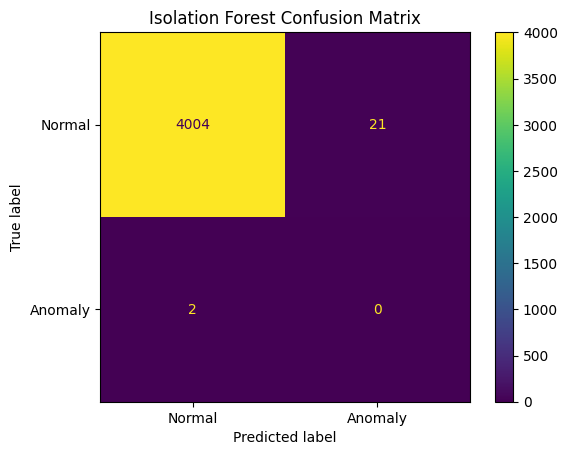

In [54]:
# Convert predictions to match the known anomaly timestamps
anomaly_timestamps = ["2014-02-26 22:05:00", "2014-02-27 17:15:00"]
true_labels = np.ones(len(timestamps))
for anomaly in anomaly_timestamps:
    anomaly_dt = pd.to_datetime(anomaly)
    true_labels[timestamps == anomaly_dt] = -1

# Create confusion matrix
cm = confusion_matrix(true_labels, preds, labels=[1, -1])
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
display_cm.plot()

plt.title('Isolation Forest Confusion Matrix')
plt.grid(False)
plt.show()